# Neural networks in activity recognition

Engineering effective features is one of the most laborious parts of machine
learning. 
The appeal of modern neural networks is that feature enginnering is 
integrated into the training process &mdash; they automatically engineer
features that are relevant for the learning task, directly from the raw
representation of the data

## Setup

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from tqdm.auto import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))


Using cuda device: 0


## Load dataset 

In [2]:

DATASET_PATH = 'dataset/'  # path to your extracted windows

with open(DATASET_PATH+'info.json', 'r') as f:
    info = json.load(f)

X = np.memmap(DATASET_PATH+'X.dat', mode='r', dtype=info['X_dtype'], shape=tuple(info['X_shape']))
Y = np.memmap(DATASET_PATH+'Y.dat', mode='r', dtype=info['Y_dtype'], shape=tuple(info['Y_shape']))
T = np.memmap(DATASET_PATH+'T.dat', mode='r', dtype=info['T_dtype'], shape=tuple(info['T_shape']))
P = np.memmap(DATASET_PATH+'P.dat', mode='r', dtype=info['P_dtype'], shape=tuple(info['P_shape']))

labels = np.unique(Y)
num_labels = len(labels)

Y = np.where(Y.reshape(-1,1)==labels)[1]  # to numeric

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('T shape:', T.shape)
print('P shape:', P.shape)


X shape: (294309, 3000, 3)
Y shape: (294309,)
T shape: (294309,)
P shape: (294309,)


## Train/test split

In [3]:

# Take out 10 participants
test_ids = ['002', '003', '004', '005', '006', 
            '007', '008', '009', '010', '011']
mask_test = np.isin(P, test_ids)
mask_train = ~mask_test
X_train, Y_train, P_train, T_train = \
    utils.ArrayFromMask(X, mask_train), Y[mask_train], P[mask_train], T[mask_train]
X_test, Y_test, P_test, T_test = \
    utils.ArrayFromMask(X, mask_test), Y[mask_test], P[mask_test], T[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (274462, 3000, 3)
Shape of X_test: (19847, 3000, 3)


## Architecture design

As a baseline, let's use a convolutional neural network (CNN) with a
typical pyramid-like structure. The input to the network is a `(N,3,3000)`
array, corresponding to `N` windows of raw tri-axial accelerometer measures.
Note the transposed format `(3,3000)` instead of `(3000,3)`; this *channels
first* format is the default in PyTorch.

The output of the CNN is a `(N,num_labels)` array where each row contains
predicted unnormalized class scores or *logits*; pass each row to a softmax
if you want to convert it to probabilities.

In [4]:
class ConvBNReLU(nn.Module):
    ''' Convolution + batch normalization + ReLU is a common trio '''
    def __init__(
        self, in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels, out_channels,
                kernel_size, stride, padding, bias=bias),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.main(x)


class CNN(nn.Module):
    ''' Typical CNN design with pyramid-like structure '''
    def __init__(self, output_size=5, in_channels=3, num_filters_init=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init,
            8, 4, 2, bias=False),  # 1500 -> 750
            ConvBNReLU(num_filters_init, num_filters_init*2,
            6, 4, 2, bias=False),  # 750 -> 188
            ConvBNReLU(num_filters_init*2, num_filters_init*4,
            8, 4, 2, bias=False),  # 188 -> 47
            ConvBNReLU(num_filters_init*4, num_filters_init*8,
            3, 2, 1, bias=False),  # 47 -> 24
            ConvBNReLU(num_filters_init*8, num_filters_init*16,
            4, 2, 1, bias=False),  # 24 -> 12
            ConvBNReLU(num_filters_init*16, num_filters_init*32,
            4, 2, 1, bias=False),  # 12 -> 6
            ConvBNReLU(num_filters_init*32, num_filters_init*64,
            6, 1, 0, bias=False),  # 6 -> 1
            nn.Conv1d(num_filters_init*64, output_size,
            1, 1, 0, bias=True)
        )

    def forward(self, x):
        return self.cnn(x).view(x.shape[0],-1)


## Helper functions


In [5]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    ''' Create a (batch) iterator over the dataset. Alternatively, use PyTorch's
    Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')  # PyTorch defaults to float32
        X_batch = np.transpose(X_batch, (0,2,1))  # channels first: (N,M,3) -> (N,3,M). PyTorch uses channel first format
        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch)
            yield X_batch, y_batch


def forward_by_batches(cnn, X):
    ''' Forward pass model on a dataset. 
    Do this by batches so that we don't blow up the memory. '''
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):  # do not shuffle here!
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()
    Y = torch.cat(Y)
    return Y


def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)  # scores
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y).to(device)).item()

    Y_pred = F.softmax(Y_pred, dim=1)  # convert to probabilities
    Y_pred = torch.argmax(Y_pred, dim=1)  # convert to classes
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    kappa = metrics.cohen_kappa_score(Y, Y_pred)

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}


 ## Hyperparameters, model instantiation, loss function and optimizer 

In [6]:
num_filters_init = 8  # initial num of filters -- see class definition
in_channels = 3  # num of channels of the signal -- equal to 3 for our raw triaxial timeseries
output_size = num_labels  # num of classes (sleep, sedentary, etc...)
num_epoch = 5  # num of epochs (full loops though the training set)
lr = 1e-3  # learning rate
batch_size = 32  # size of the mini-batch

cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)


CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(3, 8, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
        (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(8, 16, kernel_size=(6,), stride=(4,), padding=(2,), bias=False)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=

## Training


In [7]:
kappa_history = []
loss_history = []
loss_history_train = []
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(X_train, Y_train, batch_size, shuffle=True)
    losses = []
    for x, target in dataloader:
        x, target = x.to(device), target.to(device)
        cnn.zero_grad()
        output = cnn(x)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- track train loss
        losses.append(loss.item())

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch 
    # --------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(cnn, X_test, Y_test)
    loss_history.append(results['loss'])
    kappa_history.append(results['kappa'])


 ## Model performane 


Classifier performance
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.87      0.86      0.86       347
       mixed       0.52      0.56      0.54      1955
   sit-stand       0.88      0.84      0.86      8523
       sleep       0.90      0.97      0.93      7500
     vehicle       0.78      0.68      0.73       609
     walking       0.44      0.34      0.39       913

    accuracy                           0.83     19847
   macro avg       0.73      0.71      0.72     19847
weighted avg       0.83      0.83      0.83     19847



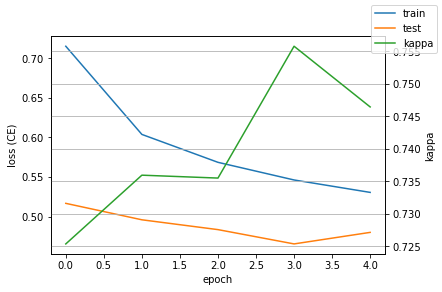

In [8]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train')
ax.plot(loss_history, color='C1', label='test')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
fig.show()

# Report
Y_test_pred_lab = labels[results['Y_pred']]  # to labels
Y_test_lab = labels[Y_test]  # to labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test_lab, Y_test_pred_lab)) 
